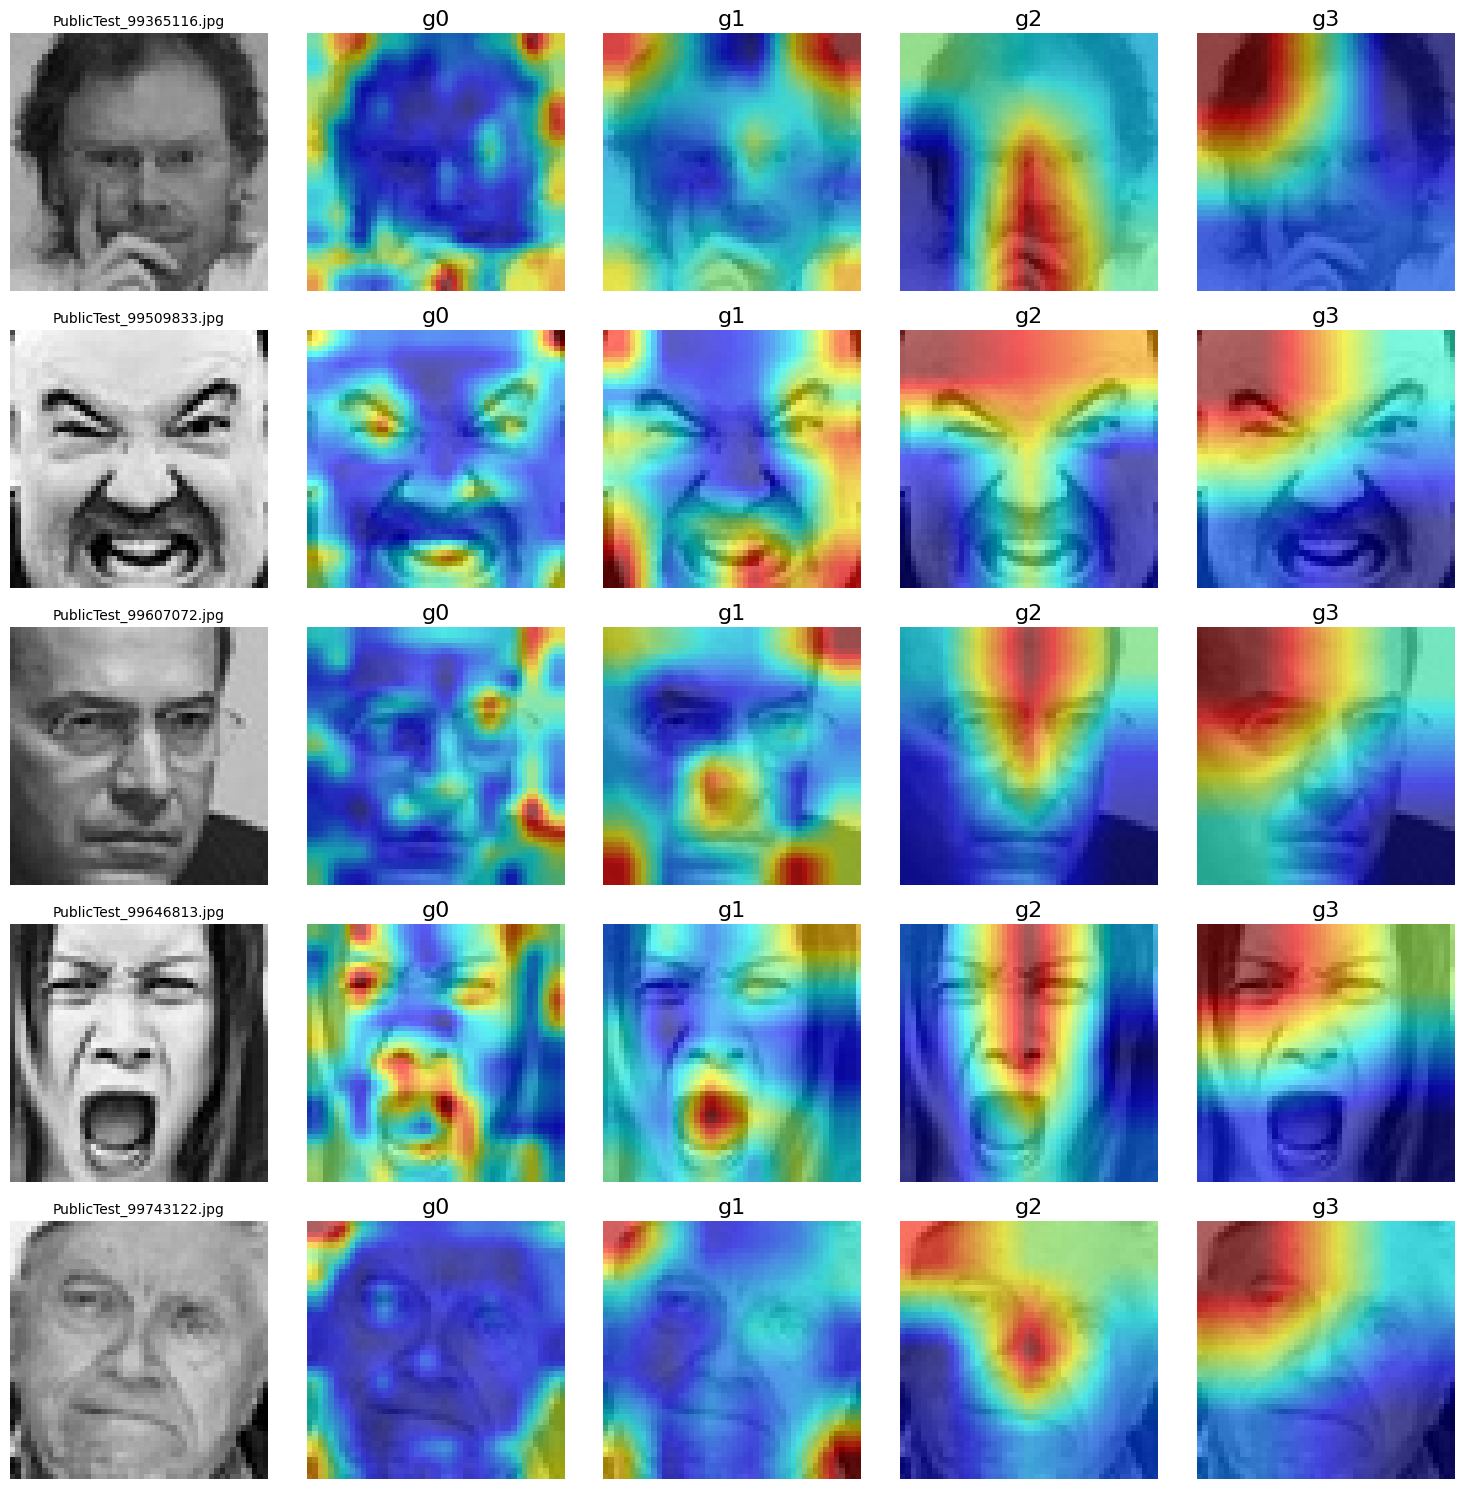

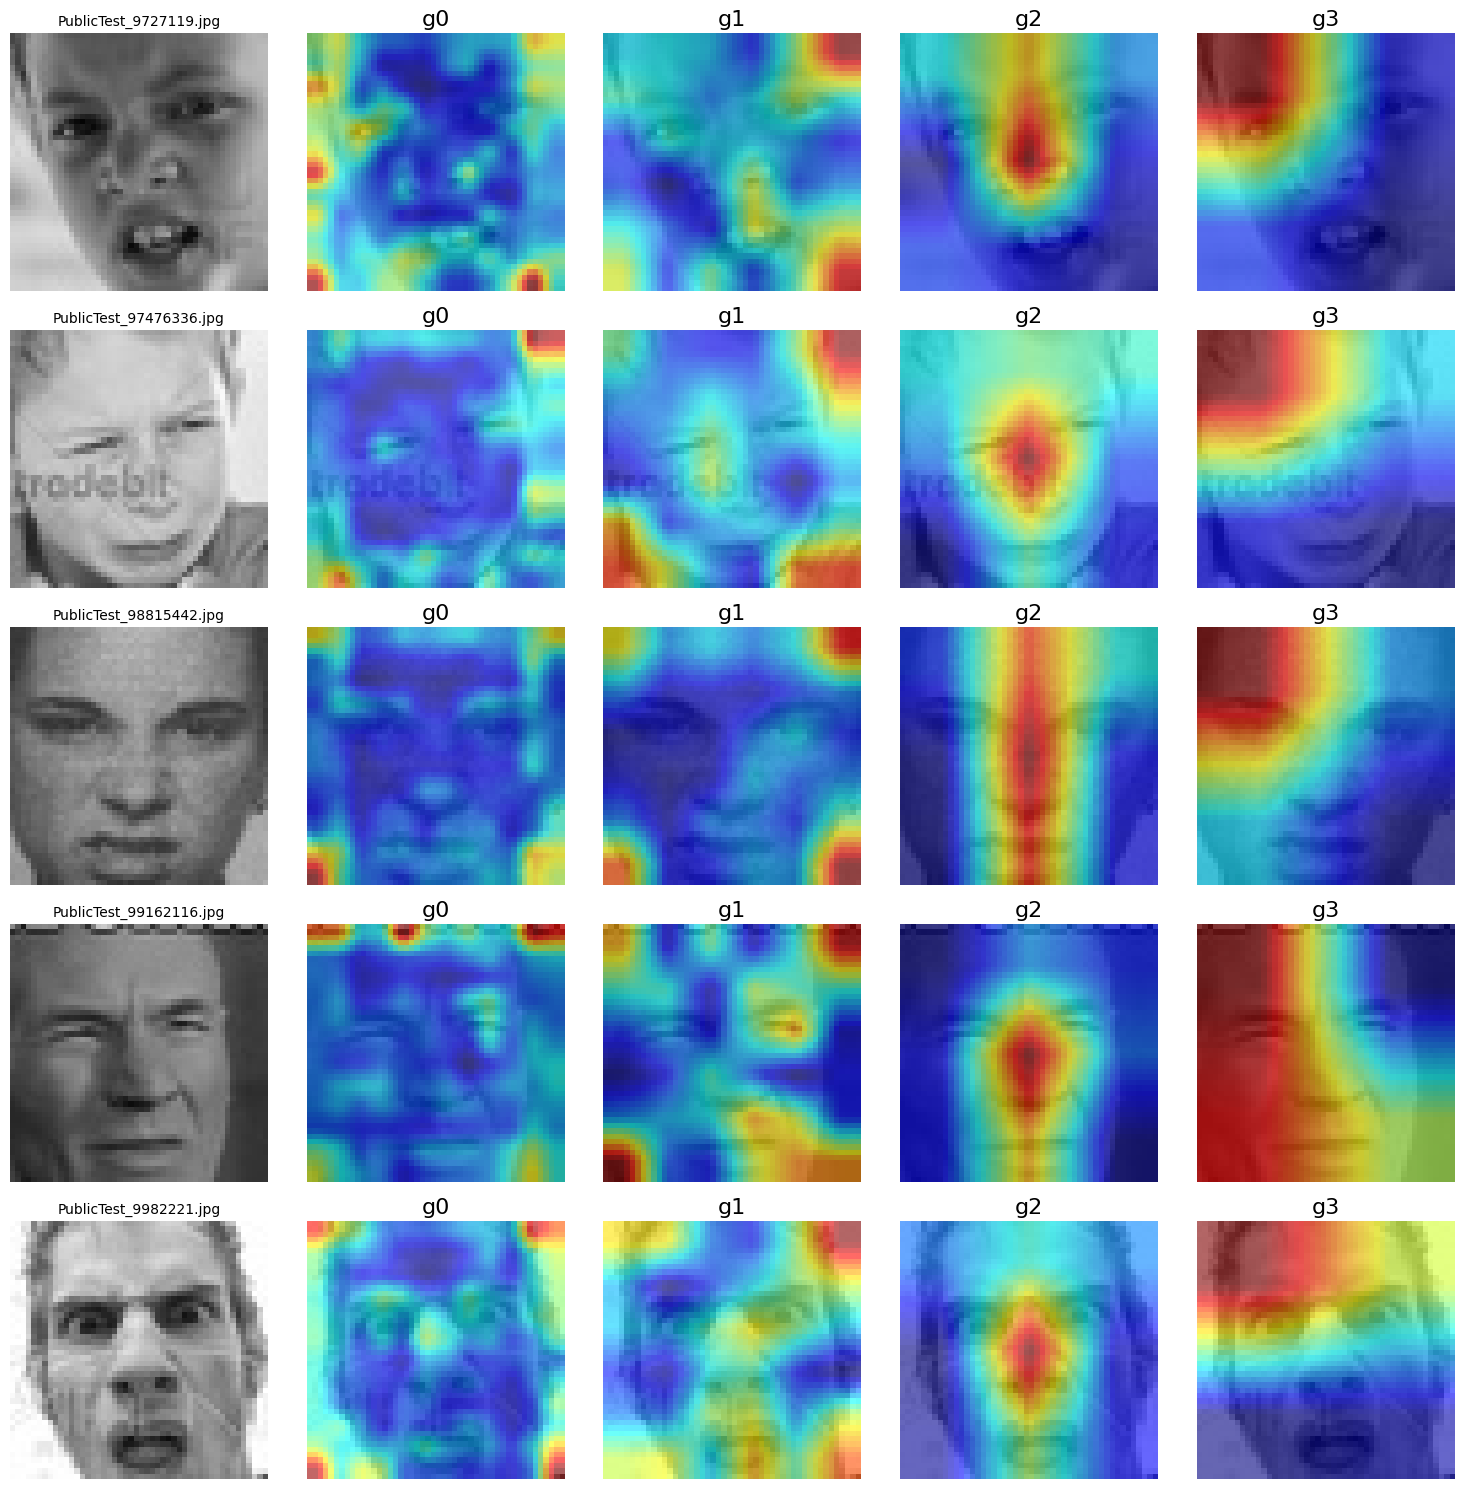

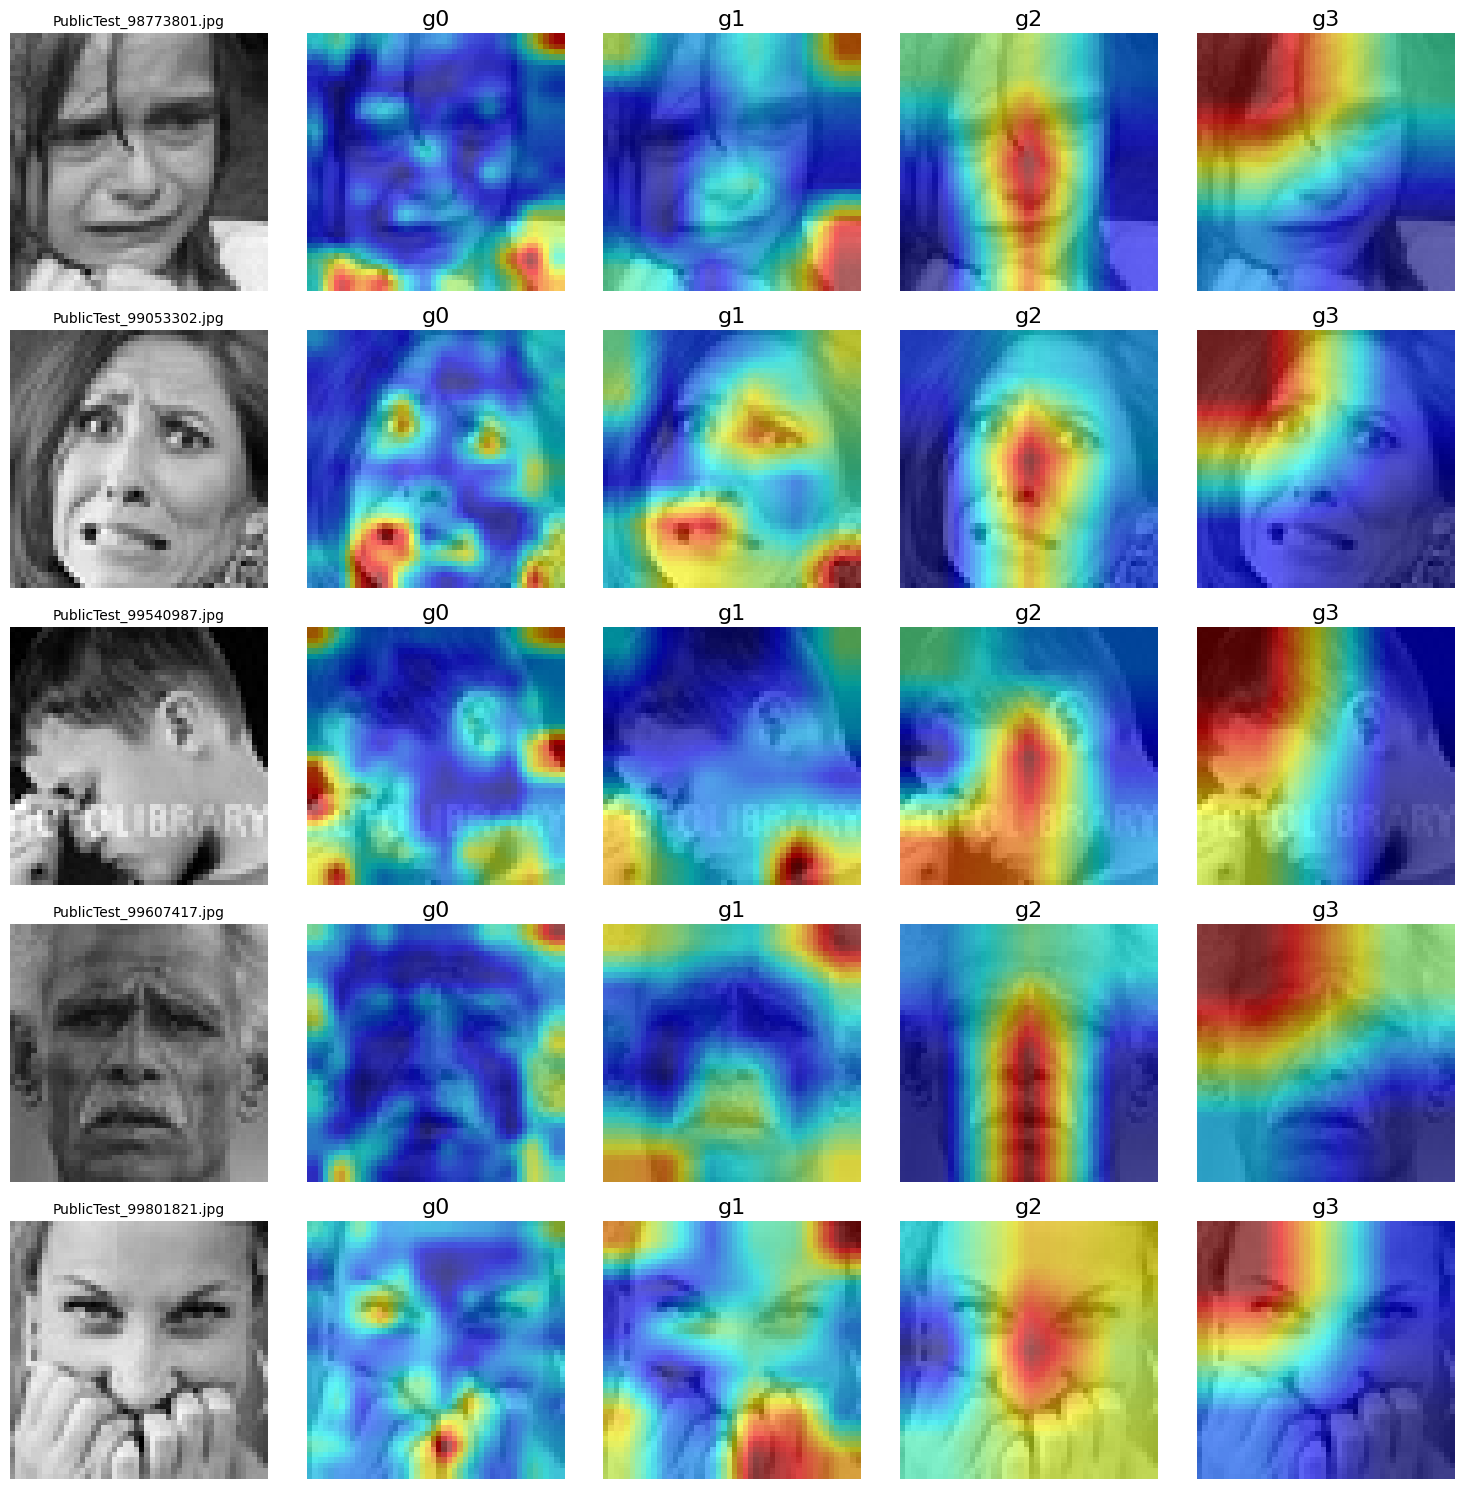

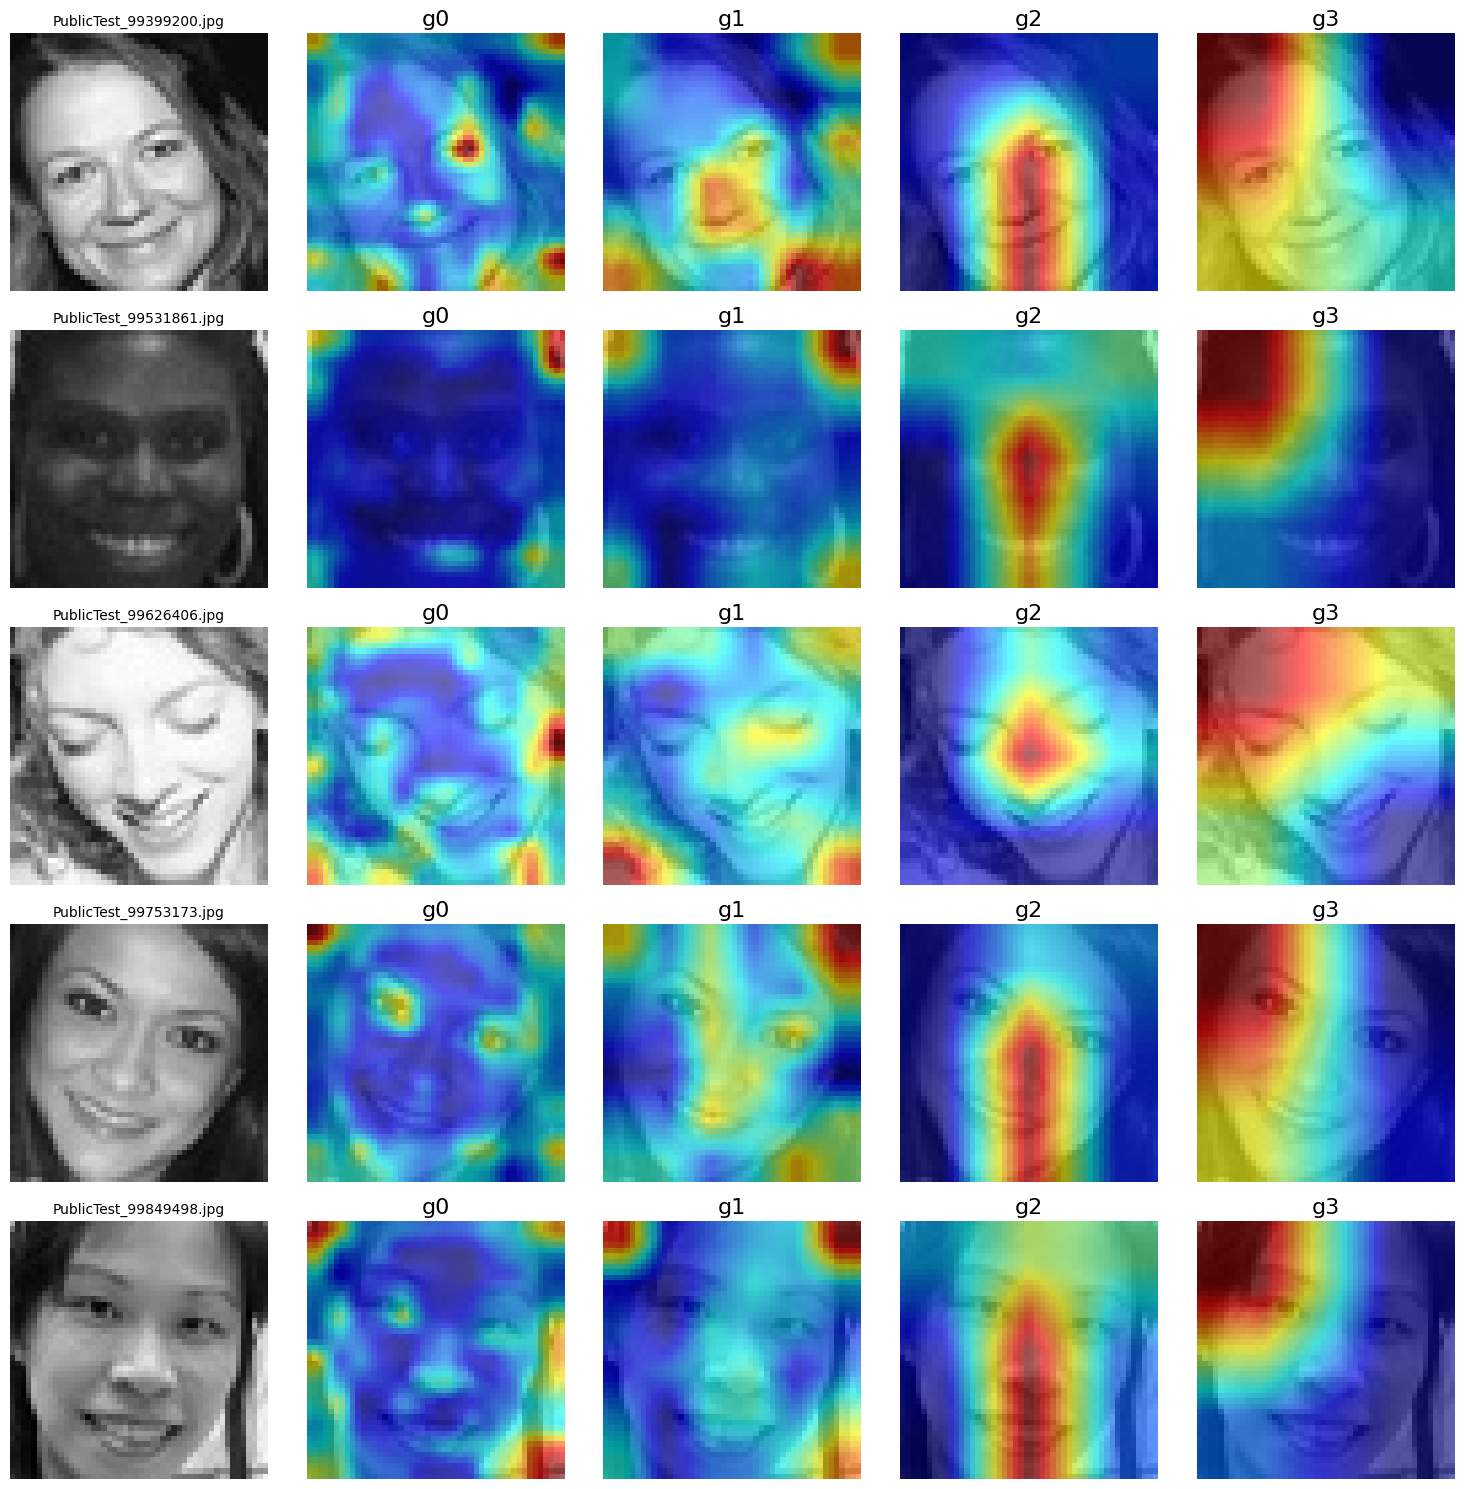

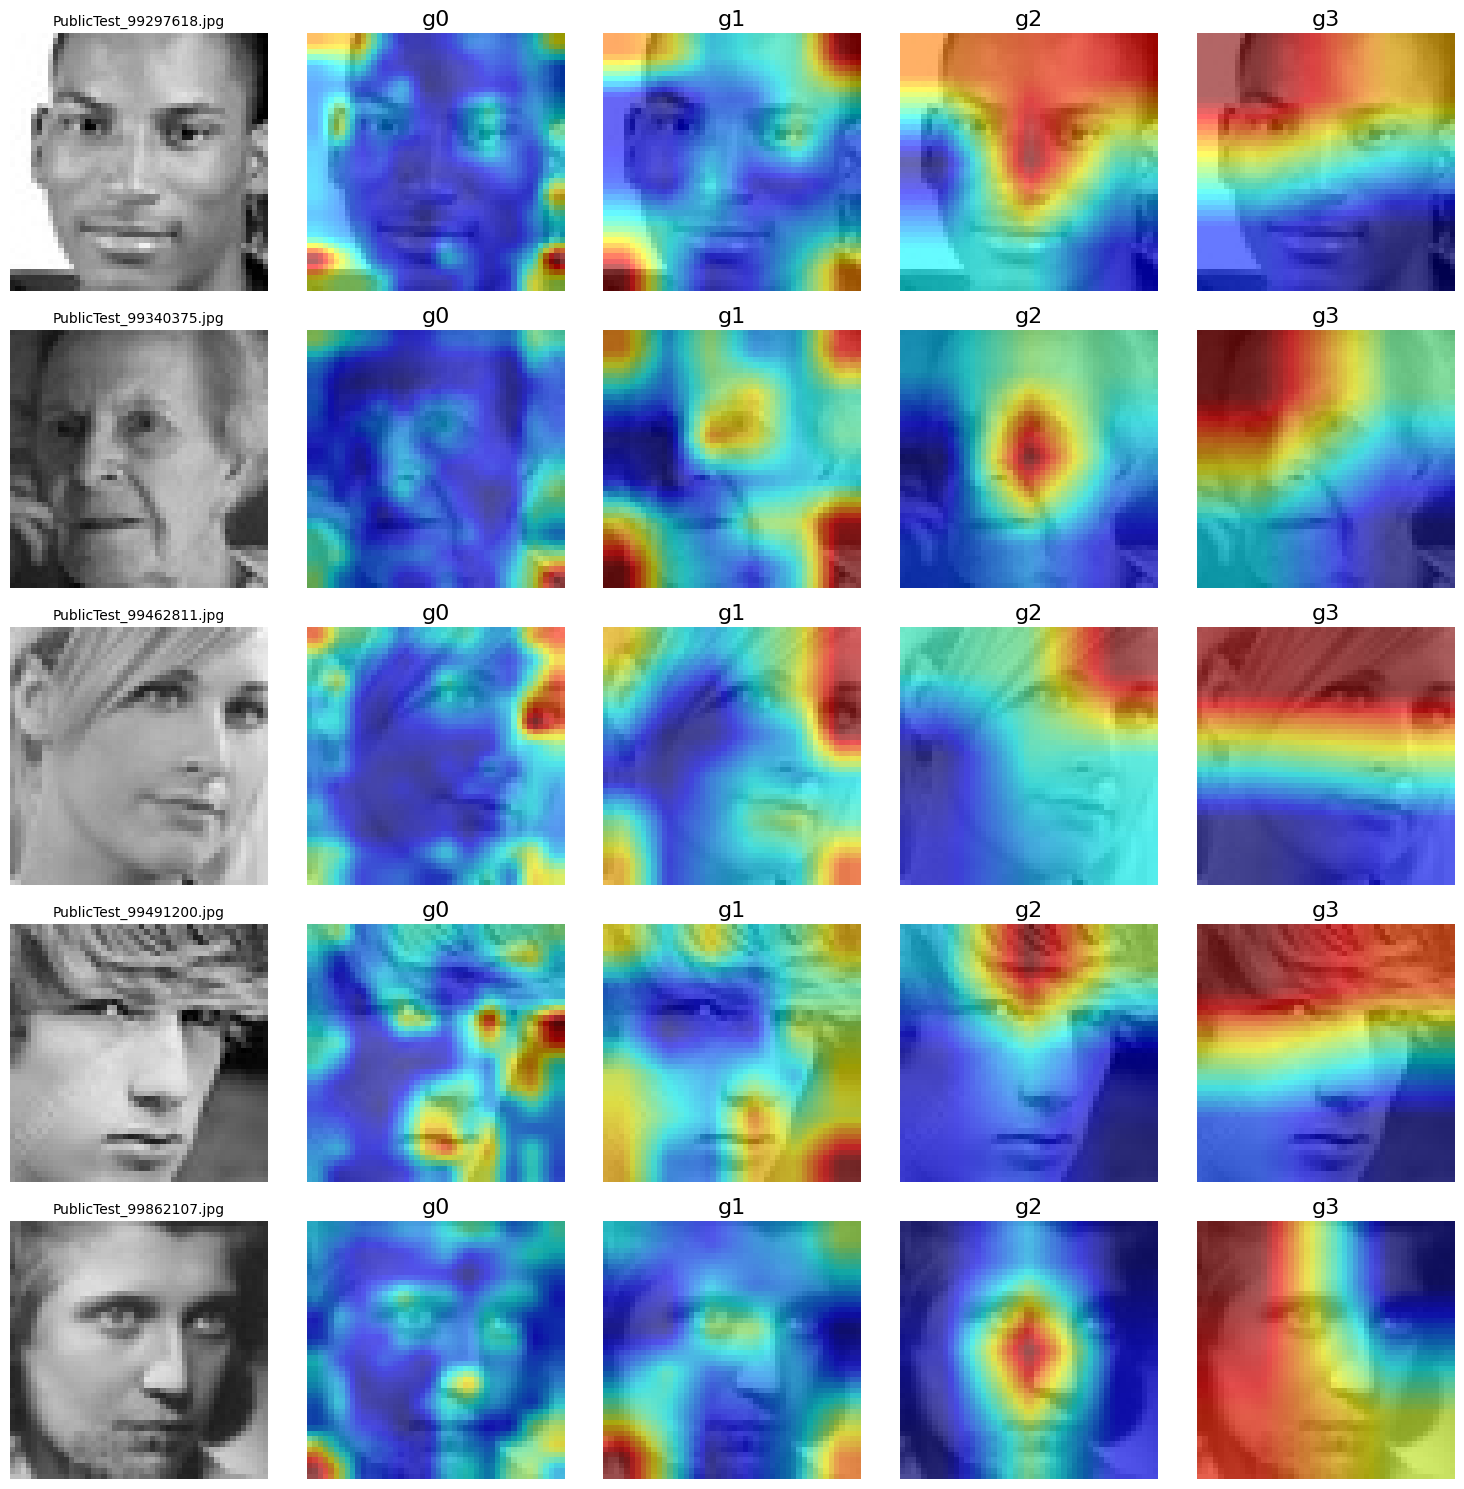

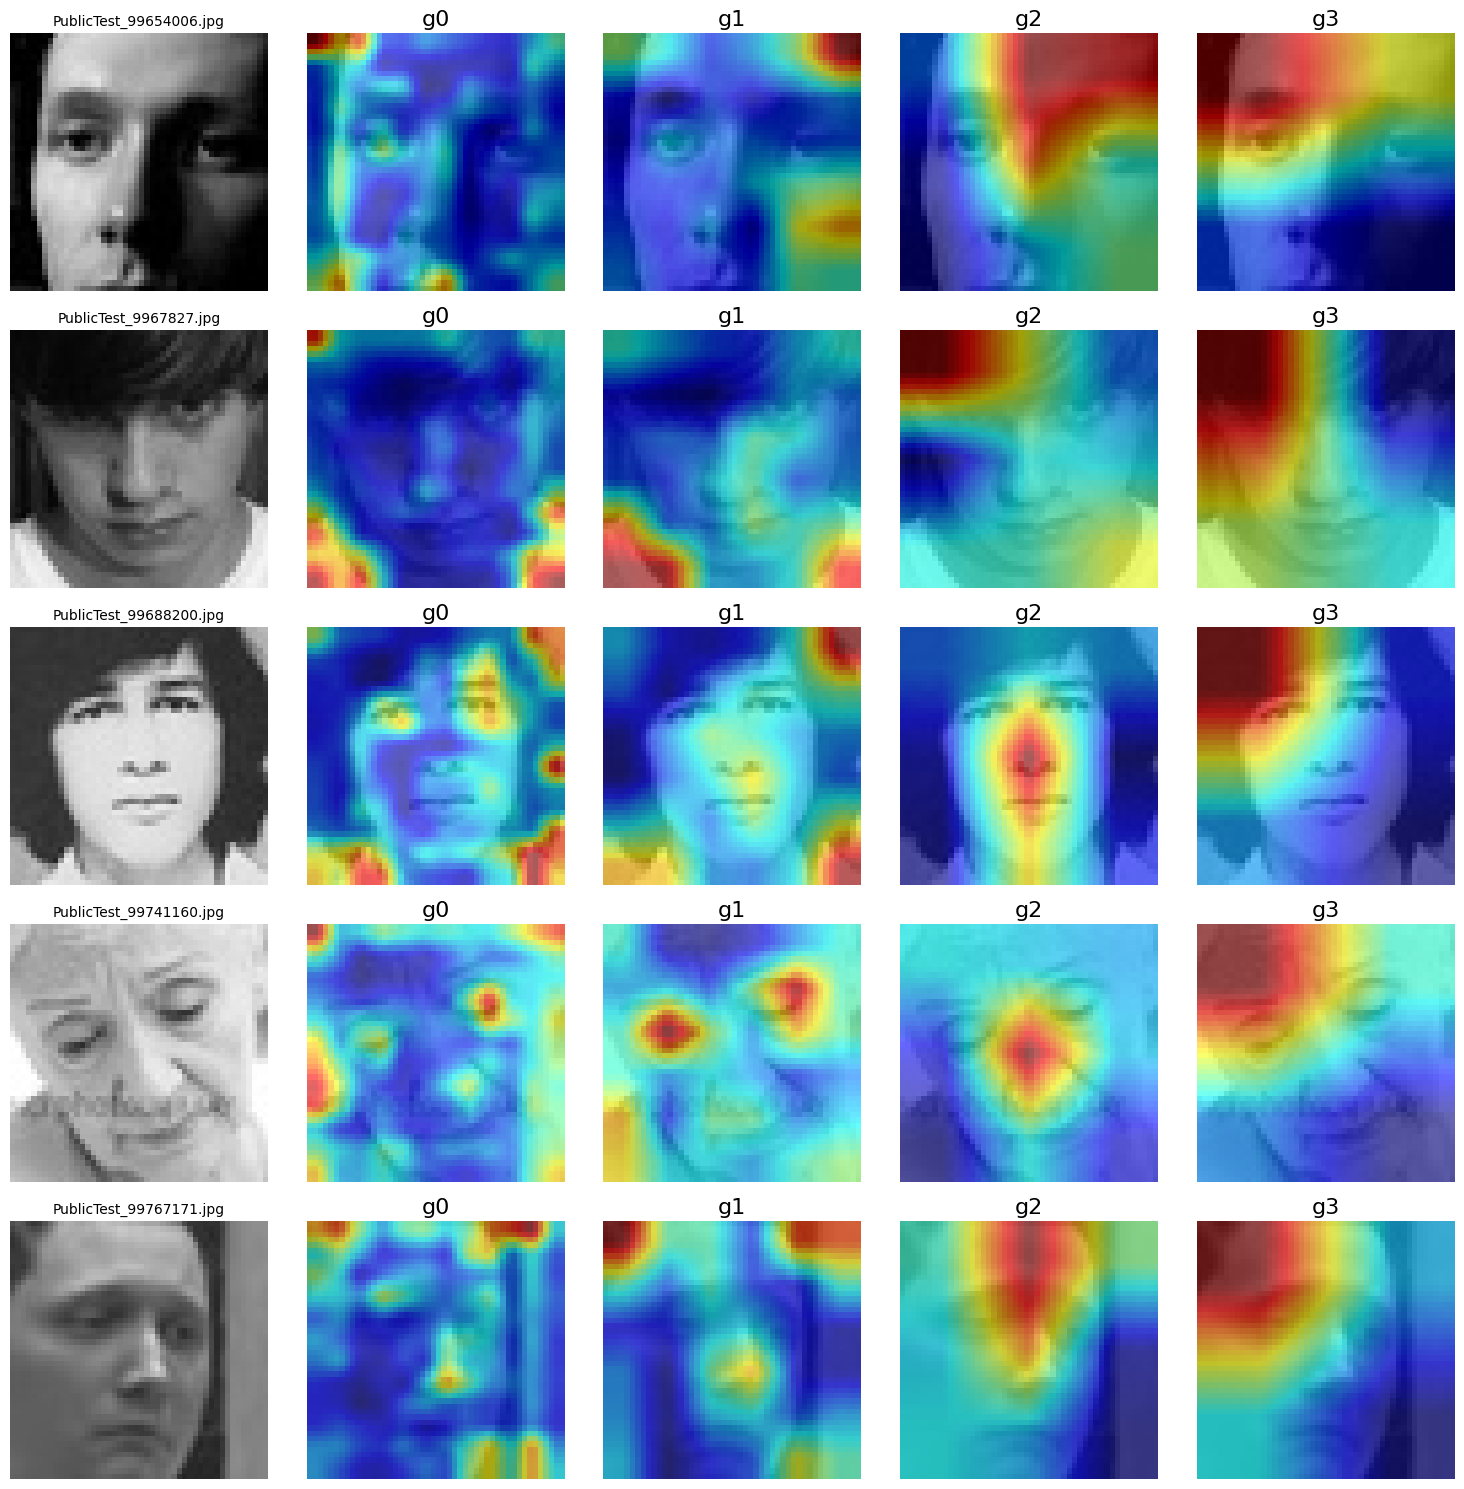

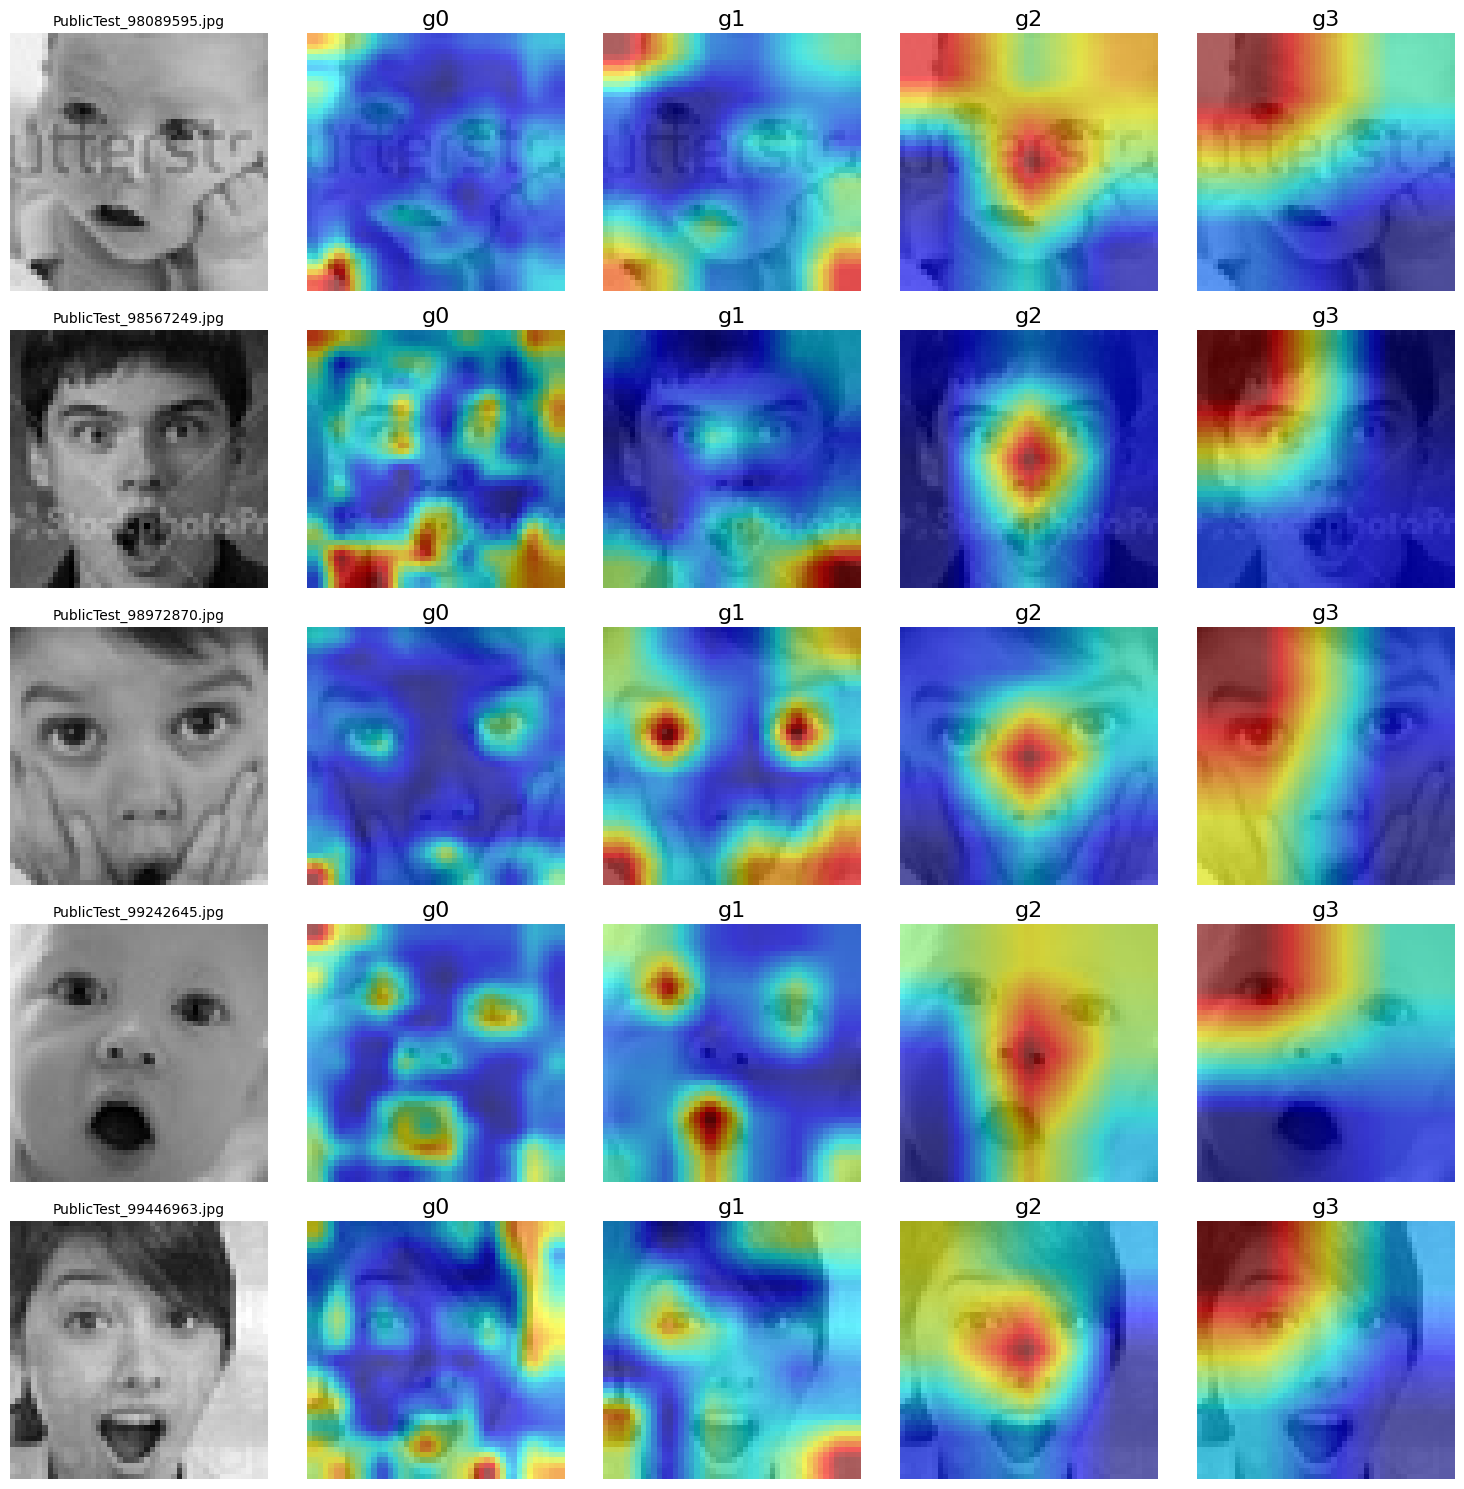

In [5]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.transforms as T
import matplotlib.pyplot as plt
from gradcam.utils import Normalize

class CustomResNet(ResNet):
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        g0 = self.layer1(x)
        g1 = self.layer2(g0)
        g2 = self.layer3(g1)
        g3 = self.layer4(g2)

        return [g.pow(2).mean(1) for g in (g0, g1, g2, g3)]

def load_model(model_path):
    base_resnet = torch.load(model_path)
    model = CustomResNet(BasicBlock, [3, 4, 6, 3])
    model.fc = nn.Linear(in_features=512, out_features=7)
    model.load_state_dict(base_resnet)
    return model

def load_images(num_images, img_dir, emotion):
    img_dir = os.path.join(img_dir, emotion)  # Update img_dir based on emotion
    images_tensor, images_numpy, file_names = [], [], []
    files = sorted(os.listdir(img_dir))

    # for file_name in files[:num_images]:
    for file_name in files[-num_images:]:  
        file_path = os.path.join(img_dir, file_name)
        img = Image.open(file_path).convert('RGB')
        img_numpy = np.array(img)
        images_numpy.append(img_numpy)

        transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img)
        images_tensor.append(img_tensor.unsqueeze(0))
        file_names.append(file_name)

    return images_tensor, images_numpy, file_names

def generate_heatmap(g, original_img):
    g = cv2.resize(g.detach().numpy(), (original_img.shape[1], original_img.shape[0]))
    g = cv2.normalize(g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmap = cv2.applyColorMap(g, cv2.COLORMAP_JET)[:, :, ::-1]
    blended_img = cv2.addWeighted(heatmap, 0.6, original_img, 0.4, 0)
    return blended_img

def visualize_results(images_tensor, images_numpy, names, model, emotion):
    num = len(images_tensor)
    fig, axes = plt.subplots(num, 5, figsize=(15, 15))

    for id, (image_tensor, image_numpy) in enumerate(zip(images_tensor, images_numpy)):
        model.eval()
        with torch.no_grad():
            gs = model(image_tensor)

            axes[id, 0].imshow(image_numpy)
            axes[id, 0].set_title(names[id], fontsize=10)
            axes[id, 0].axis('off')

            for i, g in enumerate(gs):
                heatmap = generate_heatmap(g[0], image_numpy)
                axes[id, i + 1].imshow(heatmap)
                axes[id, i + 1].set_title(f'g{i}', fontsize=16)
                axes[id, i + 1].axis('off')

    plt.tight_layout()
    plt.savefig(f'img/attentionmap_img/{emotion}.png') 
    plt.show()
    plt.close(fig) 

if __name__ == '__main__':
    model_path = 'models/model_res34.pth'
    base_dir = 'data/test/'
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    num_images = 5

    model = load_model(model_path)

    for emotion in emotions:
        images_tensor, images_numpy, names = load_images(num_images, base_dir, emotion)
        visualize_results(images_tensor, images_numpy, names, model, emotion)
